### Importing the libraries

In [1]:
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.colors as mcolors
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


c:\Users\Public\anaconda3\envs\ktrain_envvv22\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading and displaying the dataset

In [5]:

with open('SQLiV3_cleaned2.csv', 'rb') as f:

    result = chardet.detect(f.read())
df = pd.read_csv('SQLiV3_cleaned2.csv', sep=',', encoding=result['encoding'])


print(df)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [3]:
df.shape

(30614, 2)

### Process NaN values

In [ ]:
df['Label'].isna().sum() 


0

### Process duplicates

In [5]:
num_duplicates = df.duplicated().sum()
print(f"number of dublicated : {num_duplicates}")

number of dublicated : 12


In [6]:
df = df.drop_duplicates()

In [7]:
num_duplicates = df.duplicated().sum()
print(f"number of dublicated : {num_duplicates}")

number of dublicated : 0


#### 'Label' Data Distribution


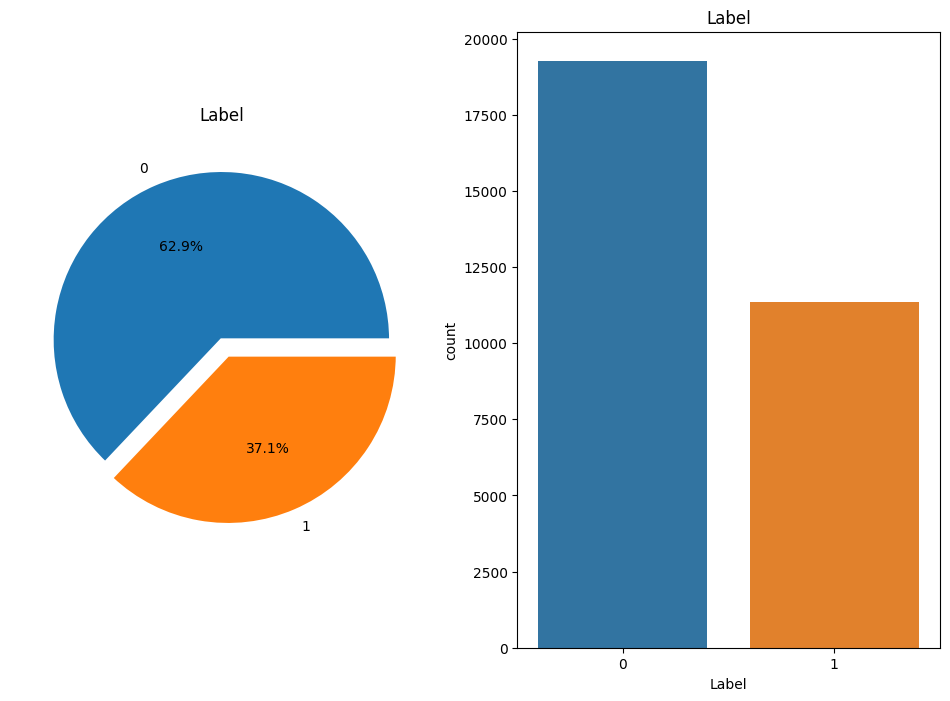

In [25]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

### Creating the training and test sets

In [6]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences, labels,
                                                                       preprocess_mode='bert',
                                                                       maxlen=100,
                                                                      val_pct=0.2,
                                                                      class_names=list(set(labels))
                                                                      )

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


### Building the BERT model

In [7]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


### Fine-tuning the BERT model

In [28]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=32)

In [29]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
766/766 [==============================] - 12073s 16s/step - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0083 - val_accuracy: 0.9972
Epoch 2/4
766/766 [==============================] - 11804s 15s/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 3/4
766/766 [==============================] - 11858s 15s/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0056 - val_accuracy: 0.9992
Epoch 4/4
766/766 [==============================] - 12402s 16s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0056 - val_accuracy: 0.9992


#### Model Validation


In [59]:
learner.validate(class_names=preproc.get_classes())


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3848
           1       1.00      1.00      1.00      2273

    accuracy                           1.00      6121
   macro avg       1.00      1.00      1.00      6121
weighted avg       1.00      1.00      1.00      6121



array([[3848,    0],
       [   5, 2268]], dtype=int64)

#### Highest Loss Predictions

In [31]:
learner.view_top_losses(n=30, preproc=preproc)

----------
id:2173 | loss:9.57 | true:1 | pred:0)

[CLS] tr ##un ##cate [SEP]
----------
id:4345 | loss:9.31 | true:1 | pred:0)

[CLS] 3 . 1 ##e + 01 ##7 [SEP]
----------
id:568 | loss:9.26 | true:1 | pred:0)

[CLS] bf ##ile ##name [SEP]
----------
id:5773 | loss:3.05 | true:1 | pred:0)

[CLS] 1 [SEP]
----------
id:701 | loss:2.23 | true:1 | pred:0)

[CLS] u ##ev [SEP]


### Plotting the training and validation loss and accuracy

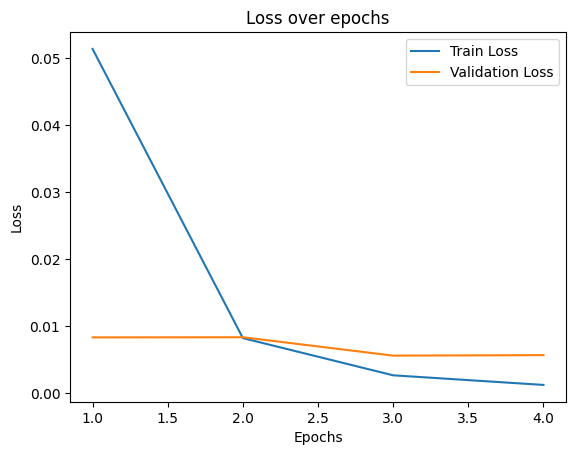

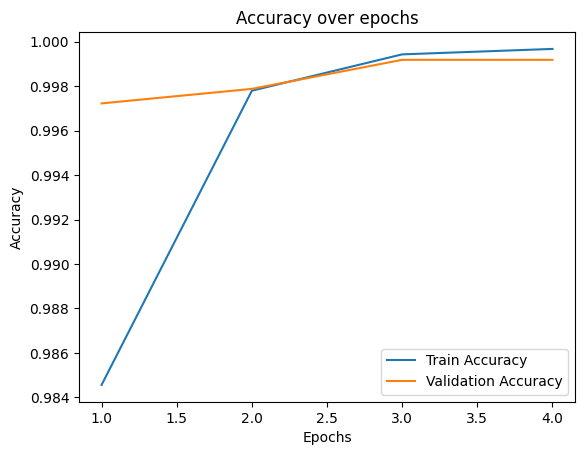

In [33]:
train_loss = learner.history.history['loss']
val_loss = learner.history.history['val_loss']
train_accuracy = learner.history.history['accuracy']
val_accuracy = learner.history.history['val_accuracy']

# Affichage des courbes de perte
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Affichage des courbes de précision
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Confusion Matrix

In [41]:
y_pred_probs = learner.model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

In [43]:
cm = confusion_matrix(y_test, y_pred)


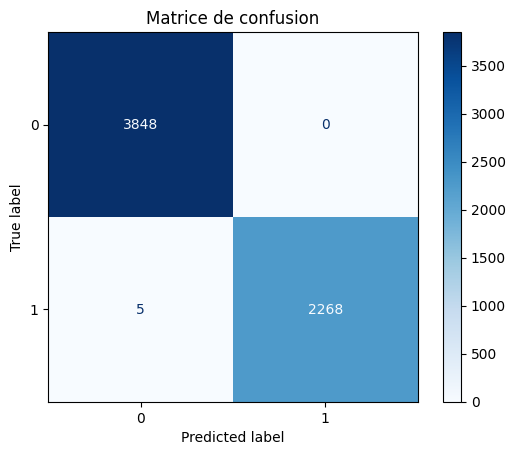

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=preproc.get_classes())
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

#### Create Predictor

In [57]:
predictor = ktrain.get_predictor(learner.model, preproc)

#### Model Saving

In [60]:
learner.save_model('bert_sqli_model')

#### Load Unseen Test Dataset

In [11]:
dataset = pd.read_csv('sqliv2_utf8.csv', sep=',',  encoding=result['encoding'])

#### Select Only Label 1 Samples

In [12]:
dataset = dataset[dataset['Label'] == 1].sample(n=500, random_state=42)

In [13]:
print(dataset)

                                                Sentence  Label
7908                                 1 where 8889 = 8889      1
101                                          admin' or '      1
7607   1'  )  )   as cpwx where 5378 = 5378 rlike  ( ...      1
4255   1  )  )   procedure analyse ( extractvalue ( 9...      1
5474   1'+ ( select 'jtvq' where 8288 = 8288 and  ( s...      1
...                                                  ...    ...
6089                1"  )  )   as itxo where 7916 = 7916      1
5466             -1351" where 6968 = 6968 or 5684 = 8582      1
8946   1'  )  )   as mjps where 2179 = 2179 union all...      1
330                       group by userid having 1 = 1--      1
11277  1"  )  )   )  and exp ( ~ ( select * from  ( s...      1

[500 rows x 2 columns]


#### Check Missing Values

In [14]:
dataset['Label'].isna().sum()

0

In [15]:
queries = dataset['Sentence'].astype(str).tolist()
labels = dataset['Label'].tolist()

In [16]:
predicted_labels = predictor.predict(queries)

In [17]:
count_label_1 = predicted_labels.count(1)
print(f"Nombre of prediction for label = 1 : {count_label_1}")

Nombre of prediction for label = 1 : 500


In [18]:
accuracy = accuracy_score(labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


In [19]:
total_queries = len(queries)

In [20]:
print(total_queries)
print(count_label_1)

500
500


In [21]:
precision = precision_score(labels, predicted_labels, pos_label=1)
recall = recall_score(labels, predicted_labels, pos_label=1)
f1 = f1_score(labels, predicted_labels, pos_label=1)
print(f"Precision (label=1): {precision:.4f}")  
print(f"Recall (label=1): {recall:.4f}")        
print(f"F1-score (label=1): {f1:.4f}")          

Precision (label=1): 1.0000
Recall (label=1): 1.0000
F1-score (label=1): 1.0000


In [22]:
dataset_0 = pd.read_csv('sqliv2_utf8.csv', sep=',',  encoding=result['encoding'])

#### Select Only Label 0 Samples

In [23]:
dataset_0 = dataset_0[dataset_0['Label'] == 0].sample(n=500, random_state=30)

In [24]:
print(dataset_0)

                                Sentence  Label
32109                velilla de los ajos      0
16300                           adelaide      0
24545                               lujn      0
25076                    cuacos de yuste      0
22811  c/ zahara de los atunes, 137, 9?b      0
...                                  ...    ...
25078                   0861204544361308      0
23098                              01226      0
21794                   0989859943250311      0
20757                          84826588n      0
31546                          48573885r      0

[500 rows x 2 columns]


In [25]:
dataset_0['Label'].isna().sum()

0

In [26]:
queries_0 = dataset_0['Sentence'].astype(str).tolist()
labels_0 = dataset_0['Label'].tolist()

In [27]:
predicted_labels_0 = predictor.predict(queries_0)

In [28]:
count_label_0 = predicted_labels_0.count(0)
print(f"Nombre of prediction for label = 0 : {count_label_0}")

Nombre of prediction for label = 0 : 499


In [29]:
from sklearn.metrics import accuracy_score
accuracy_0 = accuracy_score(labels_0, predicted_labels_0)
print(f"Accuracy: {accuracy_0:.4f}")

Accuracy: 0.9980


In [30]:
total_queries_0 = len(queries_0)

In [31]:
print(total_queries_0)
print(count_label_0)

500
499


In [32]:
precision = precision_score(labels_0, predicted_labels_0, pos_label=0)
recall = recall_score(labels_0, predicted_labels_0, pos_label=0)
f1 = f1_score(labels_0, predicted_labels_0, pos_label=0)

print(f"Precision (label=0): {precision:.4f}")  
print(f"Recall (label=0): {recall:.4f}")        
print(f"F1-score (label=0): {f1:.4f}")  

Precision (label=0): 1.0000
Recall (label=0): 0.9980
F1-score (label=0): 0.9990


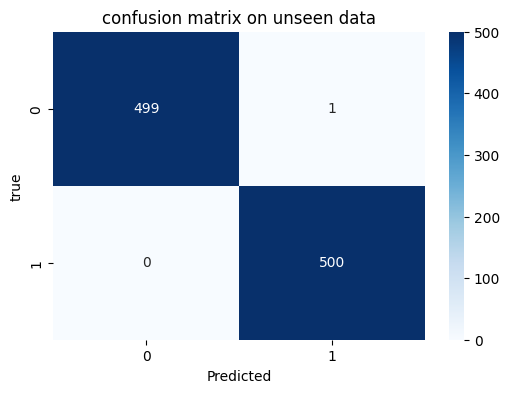

Overall accuracy: 0.9990

 Classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

all_labels = labels_0 + labels
all_predictions = predicted_labels_0 + predicted_labels
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('true')
plt.title('confusion matrix on unseen data')
plt.show()
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Overall accuracy: {accuracy:.4f}")
print("\n Classification report :")
print(classification_report(all_labels, all_predictions, digits=2))

In [55]:
# Extract the "sentences" column from each DataFrame
sentences1 = set(df['Sentence'].tolist())
sentences2 = set(dataset['Sentence'].tolist())

# Find the common sentences
common_sentences = sentences1.intersection(sentences2)

# Calculate the percentage of common sentences in the first dataset
similarity_percentage = (len(common_sentences) / len(sentences2)) * 100

# Print the similarity percentage
print(f"Similarity Percentage: {similarity_percentage}%")

Similarity Percentage: 5.2%


In [56]:
# Count the number of common sentences
common_sentence_count = len(common_sentences)
# Print the count of common sentences
print(f"Number of Common Sentences: {common_sentence_count}")

Number of Common Sentences: 26
